# Project: variant 1

Imagine that you work for a company that develops mobile games. A manager came to you with a number of tasks to study several aspects of a mobile application:

1) First of all, he is interested in the retention indicator. Write a function to calculate it.

2) In addition, the company conducted A / B testing of sets of promotional offers. Based on the available data, determine which set can be considered the best and on the basis of which metrics it is worth making the right decision.

3) Offer metrics to evaluate the results of the last past thematic event in the game.


### Groups
a - Control

b - Treatment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Task 1
Retention is one of the most important indicators in a company.

Your task is to write a function that will count the retention of players (by days from the date of registration of the player).

Let's change timestamp type to datetime type:

In [13]:
import pandas as pd

def retention_by_day(reg,auth):
    
    # Convert the "reg_ts" and "auth_ts" columns to datetime format
    reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s').dt.date
    auth.auth_ts = pd.to_datetime(auth.auth_ts, unit='s').dt.date

    # Merge 2 dataframes using "LEFT JOIN" to save users with single session.
    retention = pd.merge(reg, auth, on = "uid", how = 'left')

    # 1 auth date = 1 auth row, to be sure we dont count user twice for one day.
    retention = retention.drop_duplicates()

    # Find difference in days Authenticated and Registered
    retention['day_diff'] = retention['auth_ts'] - retention['reg_ts']

    # Set difference to integer type
    retention.day_diff = retention.day_diff.dt.days.astype(int)

    # Count retention for each day
    retention = retention.day_diff.value_counts() \
                                  .reset_index() \
                                  .rename(columns = {'day_diff':'users','index':'day_num'}) \
                                  .sort_values('day_num')

    # Normalize data
    registered = retention.users.max()

    # Percentage look
    retention.users = round(retention.users /  registered * 100, 1).astype(str) + "%"
    
    return retention

In [14]:
reg  = pd.read_csv('../shared/problem1-reg_data.csv', sep = ";")
auth = pd.read_csv('../shared/problem1-auth_data.csv', sep = ";")

In [15]:
retention = retention_by_day(reg, auth)

In [16]:
retention.head()

,day_num,users
0,0,100.0%
35,1,2.0%
17,2,4.1%
11,3,4.6%
4,4,5.2%


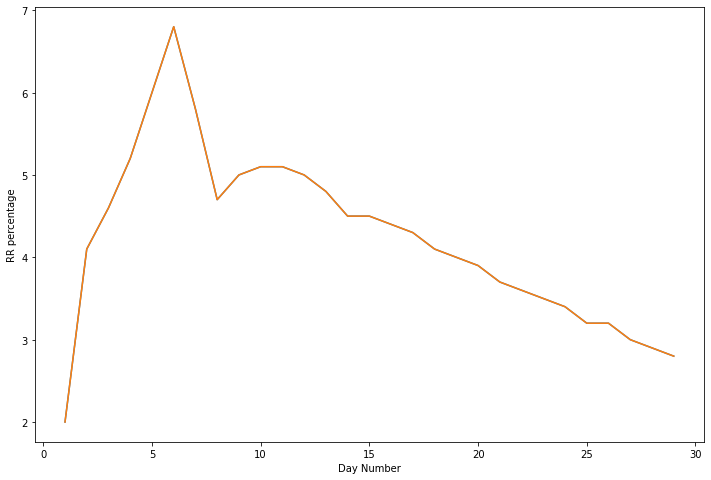

In [37]:
# RR for first 30 days (day 0 excluded)
plt.figure(figsize=(12,8))
sns.lineplot(data = retention[1:30], x = 'day_num', y = retention.users.str.replace('%','').astype(float));
ax = sns.lineplot(data = retention[1:30],
                  x = 'day_num',
                  y = retention.users.str.replace('%','').astype(float));

ax.set(xlabel='Day Number', ylabel='RR percentage')
plt.show();

# Task 2
There are results of an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group - 1805 out of 202667.

What set of proposals can be considered the best? What metrics should be analyzed to make the right decision and how?




In [2]:
data = pd.read_csv('../shared/problem2.csv', sep = ';')

In [3]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
# Check if NaN values contained

data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [5]:
# Check if revenue < 0 contained
data.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [6]:
# Check if Users occured in both groups
num_of_groups = data.groupby('user_id') \
                    .agg({'testgroup':'nunique'}) \
                    .value_counts()
num_of_groups

testgroup
1            404770
dtype: int64

No users occured in both groups, thats good.

In [7]:
# Number of users in each group

data.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

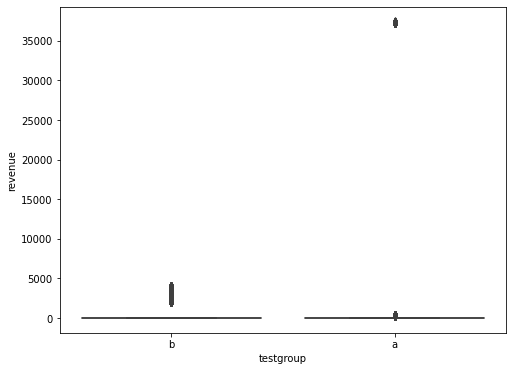

In [8]:
# Check for outliers
plt.figure(figsize=(8,6))
sns.boxplot(data = data, x = 'testgroup', y = 'revenue');

So I see 2 options to buy in Control group (a), and 1 in Treatment group. 

We know, that ARPU in the test group is 5% higher than in the control group.

Let's see <b>Average revenue per paying user (ARPPU)</b>. And make some conclusions.

In [9]:
payed = data.query('revenue > 0')

In [10]:
arppu = payed.groupby('testgroup', as_index = False) \
    .agg({'revenue':'mean'}) \
    .rename(columns = {'revenue':'ARPPU'})

In [11]:
arppu

,testgroup,ARPPU
0,a,2663.998444
1,b,3003.658172


In [15]:
3003.658172 / 2663.998444 - 1

# revenue increased by almost 13%

0.12749997236860255

## Conclusion

ARPU and ARPPU is higher in Treatment (test, b) group than in Control group.
#### So the best option to apply is Treatment monetization option.

# Task 3
a) Plants & Gardens has a limited-time themed event every month. In them, players can get unique items for the garden and characters, additional coins or bonuses. To receive a reward, you need to complete a series of levels in a certain time. What metrics can be used to evaluate the results of the last past event?

b) Suppose, in another event, we have complicated the mechanics of events so that for each unsuccessful attempt to complete the level, the player will roll back several levels. Will the set of performance evaluation metrics change? If so, how?

### Answers:

В качестве основы для оценки результатов проведения ивентов я возьму показатель вовлеченности игроков, все остальные метрики я считаю следствием и декомпозицией основной метрики. Поэтому вовлеченность всегда будет стоят во главе всех метрик. Как бы я считал показатель вовлеченности: число целевых дейтсвий за период делил бы на произведение дней и игроков. И чем выше этот показатель тем лучше.

ER = (Actions for period) / (Days * Users)

### a) 
Первое, на что бы я обратил внимание, так это какой процентаж людей участвует в ивенте. Если участвует условно 30%, то эти 30% будем сравнивать с остальными 70%, которые не участвуют. А если участвует условно более 70% игроков в ивенте, то незачем сравнивать показатели этой группы, с остальной, потому что ивент является неотъемлемой частью геймплея - люди привыкли к ивентам.

В целом, для оценки ивента я бы делил игроков на 3 сегмента:

1) участвововал и проиграл <br>
2) участвовал и победил<br>
3) не участвовал (почему?)<br>

Вот <b>метрики, на которые бы я смотрел</b>:

1)<b> ARPU</b> - если, например, уровни в ивенте очень простые, то игроки будут легче получать предметы, монеты и бонусы. Как следствие, ввиду ненадобности, отпадёт желание донатить в игру или попросту не будет смысла, тогда и метрика упадёт.

2) <b>LTV</b> - если после ивента LTV будет выше у тех, кто участвует в ивенте, но нужно привлечь внимание тех, кто ещё не участвует. Также обратил бы внимание у кого LTV выше - у тех кто выиграл в ивенте, или у тех кто проиграл, или нет разницы.

3) <b>Retention Rate</b> - отпадает ли желание у игроков играть дальше после ивента, может ли поражение в ивенте негативно отразиться на желании игрока продолжать играть? Нужно смотреть.

4) Можно добавить пару метрик типа <b>Average session time, Average Matches played</b> - и если они коррелируют с другими метриками, можно тоже посмотреть на поведение игроков.

5) <b>Level Stuck Distribuiton</b> - смотрел бы на каких уровнях люди чаще всего застревают и следил бы, чтобы они не застревали на первых уровнях и не прекращали прохождение.

### b)

Я бы оставил этот же набор метрик для оценки ивентов. 
Снизился бы процент пройденных уровней: люди очевидно фейлят и прекращают участие из-за сложности, и скорее всего больше не будут участвовать в ивентах - пропадает интерес.

Я полагаю, что такая механика ухудшит вовлеченность игроков, как следствие упадут метрики типа ARPU, LTV, Retention Rate, DAU/MAU, а также прокси метрики.


## English version:

As a basis for evaluating the results of events, I will take the player involvement indicator, I consider all other metrics to be a consequence and decomposition of the main metric. Therefore, engagement will always be at the head of all metrics. How would I calculate the engagement rate: the number of target actions for the period would be divided by the product of days and players. And the higher this figure, the better.

ER = (Actions for period) / (Days * Users)

### a)
The first thing I would pay attention to is what percentage of people participate in the event. If conditionally 30% participate, then we will compare these 30% with the remaining 70% that do not participate. And if conditionally more than 70% of the players participate in the event, then there is no need to compare the performance of this group with the rest, because the event is an integral part of the gameplay - people are used to events.

In general, to evaluate the event, I would divide the players into 3 segments:

1) participated and lost <br>
2) participated and won<br>
3) did not participate (why?)<br>

Here are the <b>metrics I would look at</b>:

1) <b>ARPU</b> - if, for example, the levels in the event are very simple, then players will be able to get items, coins and bonuses more easily. As a result, due to uselessness, the desire to donate to the game will disappear or there will simply be no point, then the metric will fall.

2) <b>LTV</b> - if after the event LTV will be higher for those who participate in the event, but you need to attract the attention of those who do not participate yet. I would also pay attention to who has a higher LTV - those who won the event, or those who lost, or there is no difference.

3) <b>Retention Rate</b> - does the player's desire to play further disappear after the event, can a loss in the event negatively affect the player's desire to continue playing? Need to watch.

4) You can add a couple of metrics like <b>Average session time, Average Matches played</b> - and if they correlate with other metrics, you can also look at the behavior of the players.

5) <b>Level Stuck Distribuiton</b> - I would look at what levels people get stuck most often and make sure that they do not get stuck on the first levels and do not stop passing.

### b)

I would leave the same set of metrics for evaluating results of events.
The percentage of completed levels would decrease: people obviously fail and stop participating because of the difficulty, and most likely they will no longer participate in events - interest is lost.

I believe that such a mechanic will worsen the involvement of players, as a result, metrics such as ARPU, LTV, Retention Rate, DAU / MAU, as well as proxy metrics will decrease.